https://www.r-bloggers.com/how-to-perform-a-logistic-regression-in-r/

predictors 相当于features

In [3]:
training_data_raw <- read.csv('train.csv',header=T,na.strings=c(""))

In [12]:
class(training_data_raw)

[1] "data.frame"

In [13]:
training_data_raw[1,]

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,NA,S


In [4]:
sapply(training_data_raw,function(x) sum(is.na(x))) # 空值

PassengerId    Survived      Pclass        Name         Sex         Age 
          0           0           0           0           0         177 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0         687           2

In [5]:
sapply(training_data_raw, function(x) length(unique(x)))

PassengerId    Survived      Pclass        Name         Sex         Age 
        891           2           3         891           2          89 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          7           7         681         248         148           4

also installing the dependency 'RcppArmadillo'



package 'RcppArmadillo' successfully unpacked and MD5 sums checked
package 'Amelia' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\k\AppData\Local\Temp\Rtmpkt2pl8\downloaded_packages


Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.7.4, built: 2015-12-05)
## Copyright (C) 2005-2018 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 


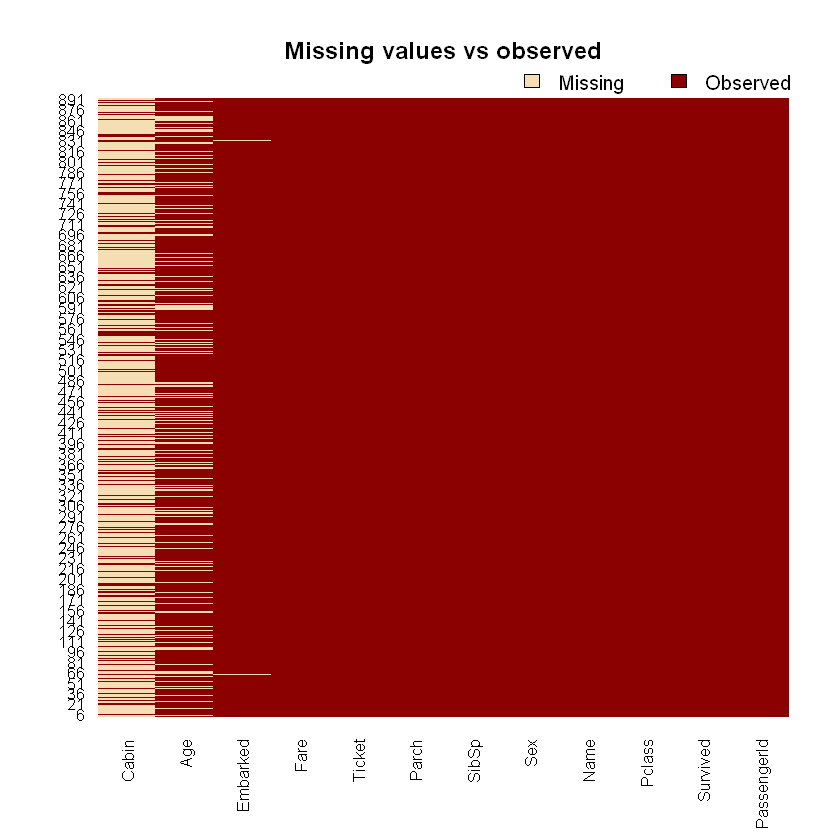

In [7]:
install.packages('Amelia')
library(Amelia)
missmap(training_data_raw, main = "Missing values vs observed")

The variable cabin has too many missing values, we will not use it. We will also drop PassengerId since it is only an index and Ticket.
Using the subset() function we subset the original dataset selecting the relevant columns only.



In [14]:
training_data_raw[1,]

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,NA,S


In [8]:
data <- subset(training_data_raw,select=c(2,3,5,6,7,8,10,12))

Now we need to account for the other missing values. R can easily deal with them when fitting a generalized linear model by setting a parameter inside the fitting function. However, personally I prefer to replace the NAs “by hand”, when is possible. There are different ways to do this, a typical approach is to replace the missing values with the average, the median or the mode of the existing one. I’ll be using the average.

In [15]:
data$Age[is.na(data$Age)] <- mean(data$Age,na.rm=T)# 计算非空值的平均值然后赋值给空值

As far as categorical variables are concerned, using the read.table() or read.csv() by default will encode the categorical variables as factors. A factor is how R deals categorical variables.
We can check the encoding using the following lines of code



In [16]:
is.factor(data$Sex)

[1] TRUE

In [17]:
is.factor(data$Embarked)

[1] TRUE

For a better understanding of how R is going to deal with the categorical variables, we can use the contrasts() function. This function will show us how the variables have been dummyfied by R and how to interpret them in a model.

In [18]:
contrasts(data$Sex)

,male
female,0
male,1


In [19]:
contrasts(data$Embarked)

,Q,S
C,0,0
Q,1,0
S,0,1


For instance, you can see that in the variable sex, female will be used as the reference. As for the missing values in Embarked, since there are only two, we will discard those two rows (we could also have replaced the missing values with the mode and keep the datapoints)

In [20]:
data <- data[!is.na(data$Embarked),]
rownames(data) <- NULL

Before proceeding to the fitting process, let me remind you how important is cleaning and formatting of the data. This preprocessing step often is crucial for obtaining a good fit of the model and better predictive ability.

In [21]:
train <- data[1:800,]
test <- data[801:889,]

In [22]:
model <- glm(Survived ~.,family=binomial(link='logit'),data=train)

In [23]:
summary(model)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6064  -0.5954  -0.4254   0.6220   2.4165  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  5.137627   0.594998   8.635  < 2e-16 ***
Pclass      -1.087156   0.151168  -7.192 6.40e-13 ***
Sexmale     -2.756819   0.212026 -13.002  < 2e-16 ***
Age         -0.037267   0.008195  -4.547 5.43e-06 ***
SibSp       -0.292920   0.114642  -2.555   0.0106 *  
Parch       -0.116576   0.128127  -0.910   0.3629    
Fare         0.001528   0.002353   0.649   0.5160    
EmbarkedQ   -0.002656   0.400882  -0.007   0.9947    
EmbarkedS   -0.318786   0.252960  -1.260   0.2076    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1065.39  on 799  degrees of freedom
Residual deviance:  709.39  on 791  degrees of freedom
AIC: 7

Now we can analyze the fitting and interpret what the model is telling us.
First of all, we can see that SibSp, Fare and Embarked are not statistically significant. As for the statistically significant variables, sex has the lowest p-value suggesting a strong association of the sex of the passenger with the probability of having survived. The negative coefficient for this predictor suggests that all other variables being equal, the male passenger is less likely to have survived. Remember that in the logit model the response variable is log odds: ln(odds) = ln(p/(1-p)) = a*x1 + b*x2 + … + z*xn. Since male is a dummy variable, being male reduces the log odds by 2.75 while a unit increase in age reduces the log odds by 0.037.

Now we can run the anova() function on the model to analyze the table of deviance

In [24]:
anova(model, test="Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,799,1065.3922,NA
Pclass,1,83.6069449,798,981.7853,6.036064e-20
Sex,1,240.0135513,797,741.7717,3.906166e-54
Age,1,17.4946765,796,724.2770,2.881133e-05
SibSp,1,10.8423921,795,713.4346,9.920249e-04
Parch,1,0.8630972,794,712.5715,3.528734e-01
Fare,1,0.9942053,793,711.5773,3.187167e-01
Embarked,2,2.1873120,791,709.3900,3.349895e-01


The difference between the null deviance and the residual deviance shows how our model is doing against the null model (a model with only the intercept). The wider this gap, the better. Analyzing the table we can see the drop in deviance when adding each variable one at a time. Again, adding Pclass, Sex and Age significantly reduces the residual deviance. The other variables seem to improve the model less even though SibSp has a low p-value. A large p-value here indicates that the model without the variable explains more or less the same amount of variation. Ultimately what you would like to see is a significant drop in deviance and the AIC.

While no exact equivalent to the R2 of linear regression exists, the McFadden R2 index can be used to assess the model fit.

In [25]:
install.packages('pscl')
library(pscl)
pR2(model)

package 'pscl' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\k\AppData\Local\Temp\Rtmpkt2pl8\downloaded_packages


Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis


llh      llhNull           G2     McFadden         r2ML         r2CU 
-354.6950111 -532.6961008  356.0021794    0.3341513    0.3591775    0.4880244

 By setting the parameter type='response', R will output probabilities in the form of P(y=1|X). Our decision boundary will be 0.5. If P(y=1|X) > 0.5 then y = 1 otherwise y=0. Note that for some applications different thresholds could be a better option.

In [26]:
fitted.results <- predict(model,newdata=subset(test,select=c(2,3,4,5,6,7,8)),type='response')

In [27]:
fitted.results <- ifelse(fitted.results > 0.5,1,0)
misClasificError <- mean(fitted.results != test$Survived)
print(paste('Accuracy',1-misClasificError))

[1] "Accuracy 0.842696629213483"


The 0.84 accuracy on the test set is quite a good result. However, keep in mind that this result is somewhat dependent on the manual split of the data that I made earlier, therefore if you wish for a more precise score, you would be better off running some kind of cross validation such as k-fold cross validation.

As a last step, we are going to plot the ROC curve and calculate the AUC (area under the curve) which are typical performance measurements for a binary classifier.    
The ROC is a curve generated by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings while the AUC is the area under the ROC curve. As a rule of thumb, a model with good predictive ability should have an AUC closer to 1 (1 is ideal) than to 0.5.

R语言的包太杂了...一个lr都要装这么多包...

package 'ROCR' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\k\AppData\Local\Temp\Rtmpkt2pl8\downloaded_packages


Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



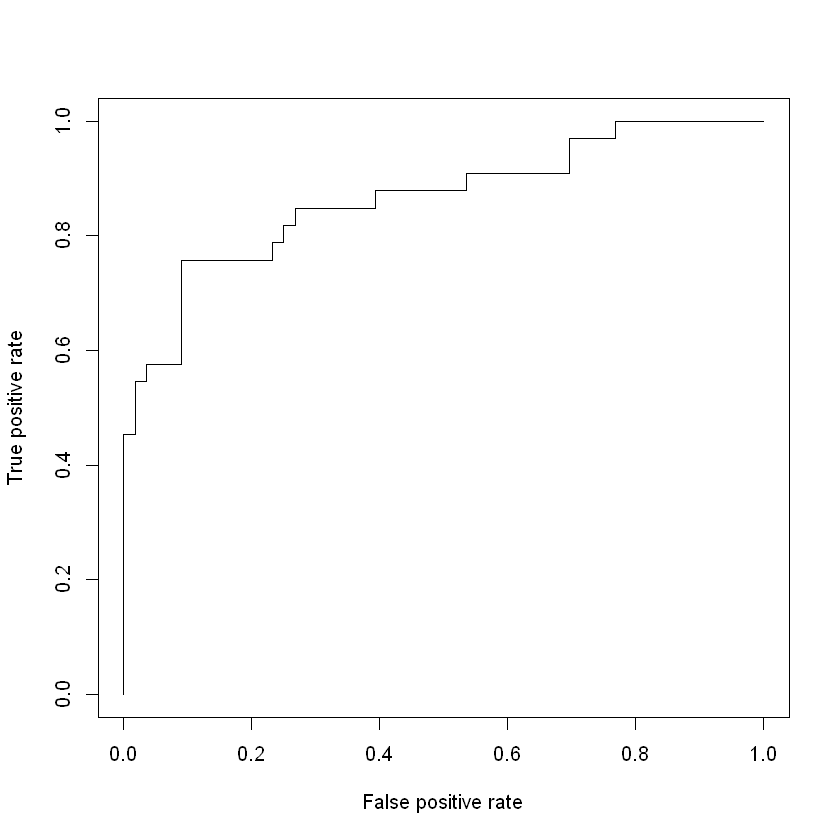

In [28]:
install.packages('ROCR')
library(ROCR)
p <- predict(model, newdata=subset(test,select=c(2,3,4,5,6,7,8)), type="response")
pr <- prediction(p, test$Survived)
prf <- performance(pr, measure = "tpr", x.measure = "fpr")
plot(prf)

In [29]:
auc <- performance(pr, measure = "auc")
auc <- auc@y.values[[1]]
auc

[1] 0.8647186